<a href="https://colab.research.google.com/github/MachokaGit/StarTalk-Youtube-Visualisation/blob/main/ChatGPT_starttalk_Countour_Chart_2hrs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

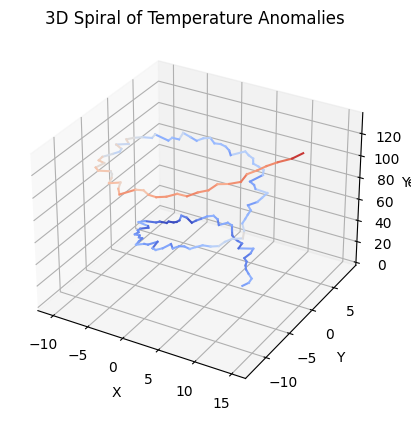

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Load the dataset
file_path = 'Globalmonthlytemps_csv.csv'
data = pd.read_csv(file_path)

# Convert 'Date' to datetime and extract the year
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year

# Group by year and calculate the mean temperature anomaly
annual_data = data.groupby('Year')['Mean'].mean().reset_index()

# Normalize the temperature data for the radii
min_anomaly = annual_data['Mean'].min()
max_anomaly = annual_data['Mean'].max()
radii = (annual_data['Mean'] - min_anomaly) / (max_anomaly - min_anomaly) * 10 + 5  # Scale and shift

# Create the 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define the color map
norm = plt.Normalize(min_anomaly, max_anomaly)
cmap = plt.get_cmap('coolwarm')

# Create the spiral
theta = np.linspace(0, 4 * np.pi, len(annual_data))  # Increase 4*pi for more coils
z = np.linspace(0, len(annual_data), len(annual_data))  # Height of the spiral

for i in range(len(annual_data)-1):
    # Compute the (x, y, z) coordinates for each circle
    x = radii.iloc[i] * np.cos(theta[i])
    y = radii.iloc[i] * np.sin(theta[i])
    z = [i, i+1]

    # Compute the color
    color = cmap(norm(annual_data.iloc[i]['Mean']))

    # Plot the circle in space
    ax.plot([x, radii.iloc[i+1] * np.cos(theta[i+1])],
            [y, radii.iloc[i+1] * np.sin(theta[i+1])],
            z,
            color=color)

# Set the labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Year')
ax.set_title('3D Spiral of Temperature Anomalies')

# Show the plot
plt.show()


In [20]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Assuming data loading and preprocessing is done here

# Generate a simple linear color scale from blue (cool) to red (warm)
color_scale = [(x, 0, 1-x) for x in np.linspace(0, 1, len(annual_data['Year']))]

# Initialize figure
fig = go.Figure()

theta = np.linspace(0, 2 * np.pi, 100)  # Circle points

for i, year in enumerate(annual_data['Year']):
    x = radii.iloc[i] * np.cos(theta)  # X coordinates
    y = radii.iloc[i] * np.sin(theta)  # Y coordinates
    z = np.full_like(theta, year)  # Z coordinates same for each point in a circle

    # Use the color scale
    color_rgb = f'rgb({int(color_scale[i][0]*255)}, {int(color_scale[i][1]*255)}, {int(color_scale[i][2]*255)})'

    fig.add_trace(go.Scatter3d(x=x, y=y, z=z,
                               mode='lines',
                               line=dict(color=color_rgb, width=4),
                               name=str(year)))

# Update layout
fig.update_layout(title='3D Spiral of Temperature Anomalies',
                  scene=dict(#xaxis_title='Degrees (cosine)',
                             #yaxis_title='Degrees (sine)',
                             zaxis_title='Year'))
# Show figure
fig.show()


In [21]:
pip install dash


In [22]:
import plotly.graph_objects as go
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd
import numpy as np

# Load the dataset
file_path = 'Globalmonthlytemps_csv.csv'
data = pd.read_csv(file_path)

# Convert 'Date' to datetime and extract the year
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year

# Group by year and calculate the mean temperature anomaly
annual_data = data.groupby('Year')['Mean'].mean().reset_index()

# Normalize the temperature data for the radii
min_anomaly = annual_data['Mean'].min()
max_anomaly = annual_data['Mean'].max()
radii = (annual_data['Mean'] - min_anomaly) / (max_anomaly - min_anomaly) * 10 + 5  # Scale and shift

# Create the spiral in 3D
theta = np.linspace(0, 2 * np.pi, 100)  # 100 points to make a full circle for each year

# Initialize figure
fig = go.Figure()

# Plot each year as a ring in the spiral
for i, year in enumerate(annual_data['Year']):
    x = radii.iloc[i] * np.cos(theta)
    y = radii.iloc[i] * np.sin(theta)
    z = np.full_like(theta, year)

     # The line color is determined by the mean temperature anomaly
    # Generate a simple linear color scale from blue (cool) to red (warm)
    color_scale = [(x, 0, 1-x) for x in np.linspace(0, 1, len(annual_data['Year']))]
    color = color_scale[i]  # Get the corresponding color from the color scale
    color_rgb = f'rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})'

    fig.add_trace(go.Scatter3d(x=x, y=y, z=z,
                               mode='lines',
                               line=dict(color=color_rgb, width=4),
                               name=str(year)))

# Set figure layout for a better view
fig.update_layout(title='3D Spiral of Temperature Anomalies',
                  scene=dict(
                      xaxis_title='Degrees (cosine)',
                      yaxis_title='Degrees (sine)',
                      zaxis_title='Year'))

# Create a Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(figure=fig, id='spiral-chart'),
    dcc.RangeSlider(
        id='year-slider',
        min=min(annual_data['Year']),
        max=max(annual_data['Year']),
        step=1,
        marks={str(year): str(year) for year in range(min(annual_data['Year']), max(annual_data['Year'])+1)},
        value=[min(annual_data['Year']), max(annual_data['Year'])]  # Initial range
    )
])

@app.callback(
    Output('spiral-chart', 'figure'),
    Input('year-slider', 'value')
)
def update_chart(selected_years):
    # Filter the data based on the selected year range
    filtered_data = annual_data[(annual_data['Year'] >= selected_years[0]) & (annual_data['Year'] <= selected_years[1])]

    # Create the spiral for the selected years
    updated_fig = go.Figure()
    for i, year in enumerate(filtered_data['Year']):
        x = radii.iloc[i] * np.cos(theta)
        y = radii.iloc[i] * np.sin(theta)
        z = np.full_like(theta, year)

        color = color_scale[i]
        color_rgb = f'rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})'

        updated_fig.add_trace(go.Scatter3d(x=x, y=y, z=z,
                                           mode='lines',
                                           line=dict(color=color_rgb, width=4),
                                           name=str(year)))

    updated_fig.update_layout(title='3D Spiral of Temperature Anomalies',
                              scene=dict(
                                  xaxis_title='Degrees (cosine)',
                                  yaxis_title='Degrees (sine)',
                                  zaxis_title='Year'))

    return updated_fig

if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

In [23]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import time

# Load the dataset
file_path = 'Globalmonthlytemps_csv.csv'
data = pd.read_csv(file_path)

# Convert 'Date' to datetime and extract the year
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year

# Group by year and calculate the mean temperature anomaly
annual_data = data.groupby('Year')['Mean'].mean().reset_index()

# Normalize the temperature data for the radii
min_anomaly = annual_data['Mean'].min()
max_anomaly = annual_data['Mean'].max()
radii = (annual_data['Mean'] - min_anomaly) / (max_anomaly - min_anomaly) * 10 + 5  # Scale and shift

# Create the spiral in 3D
theta = np.linspace(0, 2 * np.pi, 100)  # 100 points to make a full circle for each year

# Initialize figure
fig = go.Figure()

# Create frames for animation
frames = []

# Plot each year as a ring in the spiral
for i, year in enumerate(annual_data['Year']):
    x = radii.iloc[i] * np.cos(theta)
    y = radii.iloc[i] * np.sin(theta)
    z = np.full_like(theta, year)

    # The line color is determined by the mean temperature anomaly
   # Generate a simple linear color scale from blue (cool) to red (warm)
    color_scale = [(x, 0, 1-x) for x in np.linspace(0, 1, len(annual_data['Year']))]

    color = color_scale[i]

    # Get the corresponding color from the color scale
    color_rgb = f'rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})'

    fig.add_trace(go.Scatter3d(x=x, y=y, z=z,
                               mode='lines',
                               line=dict(color=color_rgb, width=4),
                               name=str(year)))

    # Create a frame for this year's data
    frame = go.Frame(data=[go.Scatter3d(x=x, y=y, z=z,
                                       mode='lines',
                                       line=dict(color=color_rgb, width=4),
                                       name=str(year))],
                     name=str(year))

    frames.append(frame)

# Set figure layout for a better view
fig.update_layout(title='3D Spiral of Temperature Anomalies',
                  scene=dict(
                      xaxis_title='Degrees (cosine)',
                      yaxis_title='Degrees (sine)',
                      zaxis_title='Year'))

# Create the animation using frames
animation_duration = 1  # Milliseconds (adjust as needed)
animation_steps = len(frames)
frame_duration = animation_duration / animation_steps

# Define the animation settings
animation_settings = dict(
    frame=dict(duration=frame_duration, redraw=False),
    fromcurrent=True,
)

# Add Play and Pause buttons for animation control
play_button = dict(label="Play", method="animate", args=[None, animation_settings])
pause_button = dict(label="Pause", method="animate", args=[[None], animation_settings])

# Add buttons to the layout
fig.update_layout(updatemenus=[dict(type="buttons", showactive=False, buttons=[play_button, pause_button])])

# Add the frames to the animation
fig.update(frames=frames)

# Show the initial state
fig.show()


In [24]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Load your dataset and preprocess it here

# Normalize and create the radii and theta values as before

# Initialize figure
fig = go.Figure()

# Add frames to the figure for each year with the respective data
frames = []
for i, year in enumerate(annual_data['Year']):
    x = radii.iloc[i] * np.cos(theta)
    y = radii.iloc[i] * np.sin(theta)
    z = np.full_like(theta, year)

    color = color_scale[i]
    color_rgb = f'rgb({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)})'

    frame = go.Frame(data=[go.Scatter3d(
        x=x, y=y, z=z,
        mode='lines',
        line=dict(color=color_rgb, width=4)
    )], name=str(year))
    frames.append(frame)

fig.frames = frames

# Add a trace to be displayed before animation starts (optional)
fig.add_trace(go.Scatter3d(
    x=[], y=[], z=[],
    mode='lines'
))

# Add play and pause button
play_button = dict(
    type="buttons",
    buttons=[dict(label="Play",
                  method="animate",
                  args=[None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True}]),
             dict(label="Pause",
                  method="animate",
                  args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}])]
)

# Update the layout, then add slider and buttons
fig.update_layout(
    title='3D Spiral of Temperature Anomalies',
    scene=dict(xaxis_title='Degrees (cosine)', yaxis_title='Degrees (sine)', zaxis_title='Year'),
    updatemenus=[play_button]
)

# Create the slider
sliders = [{
    'steps': [{'args': [[year], {'frame': {'duration': 300, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 300}}],
               'label': year, 'method': 'animate'} for year in annual_data['Year']],
    'transition': {'duration': 300},
    'x': 0.1, 'len': 0.9, 'xanchor': 'left', 'y': 0,
    'yanchor': 'top', 'pad': {'b': 10, 't': 50}, 'currentvalue': {'visible': True, 'prefix': 'Year: '},
    'font': {'size': 12}
}]

fig.update_layout(sliders=sliders)

# Show figure
fig.show()
